# Ensemble, stacking
Feature transformation exercise
http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html

In [1]:
import numpy as np
np.random.seed(10)

import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline


/usr/local/lib/python3.4/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [5]:
X, y = make_classification(n_samples=80000)

(80000, 20)
(80000,)


In [6]:
# Let's fit a PCA and pick the top 2 dimension to visualize the data
from sklearn.decomposition import PCA

[ 0.22658274  0.06912476]
(80000, 2)


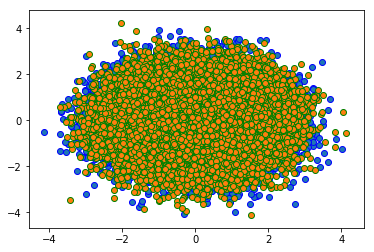

In [18]:
pca = PCA(n_components=2)
pca.fit(X, y)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)
print(X_pca.shape)
plt.scatter(X[y==0,1], X[y==0,2],label='0',edgecolors='b')
plt.scatter(X[y==1,1], X[y==1,2],label='1',edgecolors='g')
plt.show()
# it's pretty mixed

In [24]:
X_train_half, X_test_half, y_train_half, y_test_half = train_test_split(X, y, test_size=0.5)
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train_half,
                                                            y_train_half,
                                                            test_size=0.5)
print(X_train.shape, X_train_lr.shape, y_train.shape, y_train_lr.shape)

(20000, 20) (20000, 20) (20000,) (20000,)


In [44]:
# Feature transform by random trees, this trains an embedding to sparse high dimensional space
# encoded with 1-hot vector
n_trees = 10
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_trees,
    random_state=0)

# Stack with a LR model
rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train_half, y_train_half)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)


In [ ]:
# Random forest
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3)
rf.fit(X_train_half, y_train_half)
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)


In [ ]:
# Random forest stack with LR (one-hot encoding for the RF transform)
rf = RandomForestClassifier(n_estimators=n_trees, max_depth=3)
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc = OneHotEncoder()
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
y_pred_rf_lr = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(y_test, y_pred_rf_lr)



In [47]:
# Gradient boosting DT
gbdt = GradientBoostingClassifier(n_estimators=n_trees, max_depth=3)
gbdt.fit(X_train_half, y_train_half)
y_pred_gbdt = gbdt.predict_proba(X_test)[:, 1]
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_pred_gbdt)

In [52]:
# GBDT stack with LR
gbdt = GradientBoostingClassifier(n_estimators=n_trees, max_depth=3)
gbdt.fit(X_train, y_train)
gbdt_enc = OneHotEncoder()
gbdt_enc.fit(gbdt.apply(X_train)[:, :, 0])
gbdt_lr = LogisticRegression()
gbdt_lr.fit(gbdt_enc.transform(gbdt.apply(X_train_lr)[:, :, 0]), y_train_lr)
gbdt_lr_pred = gbdt_lr.predict_proba(gbdt_enc.transform(gbdt.apply(X_test)[:, :, 0]))[:, 1]
fpr_gbdt_lr, tpr_gbdt_lr, _ = roc_curve(y_test, gbdt_lr_pred)


In [ ]:
# Plot the ROC curve
plt.figure(1)
plt.clf()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.plot(fpr_gbdt, tpr_gbdt, label='GBDT')
plt.plot(fpr_gbdt_lr, tpr_gbdt_lr, label='GBDT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# zoom in
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')
plt.plot(fpr_gbdt, tpr_gbdt, label='GBDT')
plt.plot(fpr_gbdt_lr, tpr_gbdt_lr, label='GBDT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

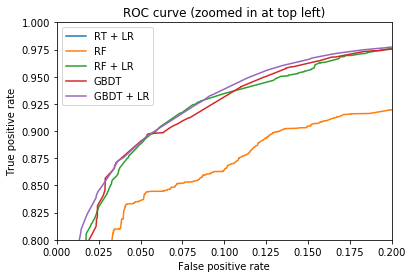

In [55]:
# AUC
print()